# HW04


## Import Libraries


In [3]:
import numpy as np
import nltk
import xml.etree.ElementTree as ET
import pandas as pd
import string
import math
import matplotlib.pyplot as plt
from functools import reduce

## Load Input


#### Description

This class is designed for loading input data related to a document collection, queries, and evaluation sets. It provides methods to read and organize data from XML files and text files.

#### Constructor

##### `__init__(self) -> None`

- **Description:** Constructor for the `LoadInput` class.
- **Attributes:**
  - `documentCollection`: A DataFrame containing information about documents loaded from the document dataset.
  - `queries`: A DataFrame containing information about queries loaded from the queries dataset.
  - `evaluationSet`: A DataFrame containing the evaluation set loaded from the evaluation dataset.
  - `binEvaluationSet`: A DataFrame containing the binary evaluation set loaded from the binary evaluation dataset.

#### Methods

##### `loadDocuments(self) -> pd.DataFrame`

- **Description:** Loads documents from the XML document dataset. Input file has a problem in xml syntax I must to handle that with split.

##### `loadQueries(self) -> pd.DataFrame`

- **Description:** Loads queries from the XML queries dataset with pandas.

##### `loadEvluationSet(self) -> pd.DataFrame`

- **Description:** Loads the evaluation set from the evaluation dataset.

##### `loadBinaryEvaluationSet(self) -> pd.DataFrame`

- **Description:** Loads the binary evaluation set from the binary evaluation dataset.


In [4]:
class LoadInput:

    DOCUMENTS_DIR_PATH = "./cranfield-trec-dataset/cran.all.1400.xml"
    QUERIES_DIR_PATH = "./cranfield-trec-dataset/cran.qry.xml"
    BIN_EVALUATION_DIR_PATH = "./cranfield-trec-dataset/cranqrel.trec.txt"
    EVALUATION_DIR_PATH = "./cran/cranqrel"

    def __init__(self) -> None:
        self.documentCollection = self.loadDocuments()
        self.queries = self.loadQueries()
        self.evalationSet = self.loadEvluationSet()
        self.binEvaluationSet = self.loadBinaryEvaluationSet()

    def loadDocuments(self)-> pd.DataFrame:
        # there exist a tag issue in input, I must to read it in this way
        documentCollection = []
        documentsXMLData = open(self.DOCUMENTS_DIR_PATH).read().split("<doc>")
        for ind in range(1, len(documentsXMLData)):
            tree = ET.fromstring("<doc>" +documentsXMLData[ind])
            document = {}
            for child in tree:
                document[child.tag] = child.text
            documentCollection.append(document)

        return pd.DataFrame(documentCollection)

    def loadQueries(self)-> pd.DataFrame:
        queries = pd.read_xml(self.QUERIES_DIR_PATH)
        queries['text'] = queries['title'].str.replace('\n', '')
        return queries
    
    def loadEvluationSet(self)-> pd.DataFrame:
        eveluationData = open(self.EVALUATION_DIR_PATH).read().split('\n')
        eveluationData =  pd.DataFrame([[int(y) for y in x.split(" ") if y!= ""] for x in eveluationData])
        eveluationData.columns = ['query_id', 'doc_id', 'relevance_score']
        return eveluationData
    
    def loadBinaryEvaluationSet(self)-> list:
        binEvaluationData = open(self.BIN_EVALUATION_DIR_PATH).read().split('\n')
        binEvaluationData =  pd.DataFrame([[int(y) for y in x.split(" ") if y!= ""] for x in binEvaluationData])
        binEvaluationData.head()
        binEvaluationData.columns = ['query_id', 'tmp' ,'doc_id', 'is_rel']
        binEvaluationData = binEvaluationData.drop('tmp', axis=1)
        return binEvaluationData

In [5]:
Input = LoadInput()

In [6]:
Input.queries.head()

,num,title,text
0,1,\nwhat similarity laws must be obeyed when con...,what similarity laws must be obeyed when const...
1,2,\nwhat are the structural and aeroelastic prob...,what are the structural and aeroelastic proble...
2,4,\nwhat problems of heat conduction in composit...,what problems of heat conduction in composite ...
3,8,\ncan a criterion be developed to show empiric...,can a criterion be developed to show empirical...
4,9,\nwhat chemical kinetic system is applicable t...,what chemical kinetic system is applicable to ...


In [7]:
Input.documentCollection.head()

,docno,title,author,bib,text
0,1,experimental investigation of the aerodynamics...,"brenckman,m.","j. ae. scs. 25, 1958, 324.",experimental investigation of the aerodynamics...
1,2,simple shear flow past a flat plate in an inco...,ting-yili,"department of aeronautical engineering, rensse...",simple shear flow past a flat plate in an inco...
2,3,the boundary layer in simple shear flow past a...,m. b. glauert,"department of mathematics, university of manch...",the boundary layer in simple shear flow past a...
3,4,approximate solutions of the incompressible la...,"yen,k.t.","j. ae. scs. 22, 1955, 728.",approximate solutions of the incompressible la...
4,5,one-dimensional transient heat conduction into...,"wasserman,b.","j. ae. scs. 24, 1957, 924.",one-dimensional transient heat conduction into...


In [8]:
Input.evalationSet.head()

,query_id,doc_id,relevance_score
0,1,184,2
1,1,29,2
2,1,31,2
3,1,12,3
4,1,51,3


In [9]:
Input.binEvaluationSet.head()

,query_id,doc_id,is_rel
0,1.0,184.0,1.0
1,1.0,29.0,1.0
2,1.0,31.0,1.0
3,1.0,12.0,1.0
4,1.0,51.0,1.0


## Document And Query Pre Processor


The `DocumentPreProcessor` providing methods to preprocess text documents. These methods perform various text processing tasks, such as converting text to lowercase, tokenization, removing punctuations, removing stop words, stemming, and lemmatization.

#### Methods

##### `__init__(self)`

- **Description**: Initializes a `DocumentPreProcessor` object by calling the constructor of the base class `LoadDocuments`.

##### `convertToLower(self)`

- **Description**: Converts all text in the loaded documents to lowercase.

##### `tokenizer(self)`

- **Description**: Tokenizes the text in the loaded documents using a regular expression pattern.

##### `removePunctuations(self)`

- **Description**: Removes punctuations from the tokenized text in the loaded documents.

##### `removeStopWords(self)`

- **Description**: Removes stop words from the tokenized text in the loaded documents using NLTK's English stop words list.

##### `stemming(self)`

- **Description**: Applies stemming to the tokenized text in the loaded documents using the Porter Stemmer algorithm from NLTK.

##### `lemmatizer(self)`

- **Description**: Applies lemmatization to the tokenized text in the loaded documents using NLTK's WordNet Lemmatizer.


In [10]:
class DocumentPreProcessor():
    def __init__(self, documentCollection : pd.DataFrame)->None:
        self.documentCollection = documentCollection

    def __removeNone(self)->None:
        self.documentCollection["text"].fillna(value= "", inplace=True)

    def __convertToLower(self)->None:
        for index in self.documentCollection.index:
            self.documentCollection["text"][index] = self.documentCollection["text"][index].lower()

    def __tokenizer(self)->None:
        pattern = r'\d{1,3}(?:,\d{3})*(?:\.\d+)?|\w+'
        for index in self.documentCollection.index:
            self.documentCollection["text"][index] = nltk.tokenize.regexp_tokenize(self.documentCollection["text"][index], pattern)

    def __removePunctuations(self)->None:
        for index in self.documentCollection.index:
            for ind, term in enumerate(self.documentCollection["text"][index]):
                self.documentCollection["text"][index][ind] = "".join([i for i in term if i not in string.punctuation])

    def __removeStopWords(self)->None:
        stopwords = nltk.corpus.stopwords.words('english')
        for index in self.documentCollection.index:
            self.documentCollection['text'][index] = [i for i in self.documentCollection['text'][index] if i not in stopwords] 

    def __stemming(self)->None:
        porter_stemmer = nltk.stem.porter.PorterStemmer()
        for index in self.documentCollection.index:
            self.documentCollection["text"][index] = [porter_stemmer.stem(term) for term in self.documentCollection["text"][index] ]

    def __lemmatizer(self)->None:
        wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
        for index in self.documentCollection.index:
            self.documentCollection["text"][index] = [wordnet_lemmatizer.lemmatize(term) for term in self.documentCollection['text'][index]]

    def exec(self)-> pd.DataFrame:
        self.__removeNone()
        self.__convertToLower()
        self.__tokenizer()
        self.__removePunctuations()
        self.__removeStopWords()
        self.__stemming()
        self.__lemmatizer()
        return self.documentCollection

In [11]:
documentPreProcessor = DocumentPreProcessor(Input.documentCollection)
Input.documentCollection = documentPreProcessor.exec()
Input.documentCollection.head()

,docno,title,author,bib,text
0,1,experimental investigation of the aerodynamics...,"brenckman,m.","j. ae. scs. 25, 1958, 324.",experimental investigation of the aerodynamics...
1,2,simple shear flow past a flat plate in an inco...,ting-yili,"department of aeronautical engineering, rensse...",simple shear flow past a flat plate in an inco...
2,3,the boundary layer in simple shear flow past a...,m. b. glauert,"department of mathematics, university of manch...",the boundary layer in simple shear flow past a...
3,4,approximate solutions of the incompressible la...,"yen,k.t.","j. ae. scs. 22, 1955, 728.",approximate solutions of the incompressible la...
4,5,one-dimensional transient heat conduction into...,"wasserman,b.","j. ae. scs. 24, 1957, 924.",one-dimensional transient heat conduction into...


In [12]:
queryPreProcessor = DocumentPreProcessor(Input.queries)
Input.queries = queryPreProcessor.exec()
Input.documentCollection.head()

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_69142/4134549522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.documentCollection["text"][index] = self.documentCollection["text"][index].lower()
/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_69142/4134549522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.documentCollection["text"][index] = self.documentCollection["text"][index].lower()
/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_69142/4134549522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

,docno,title,author,bib,text
0,1,experimental investigation of the aerodynamics...,"brenckman,m.","j. ae. scs. 25, 1958, 324.",experimental investigation of the aerodynamics...
1,2,simple shear flow past a flat plate in an inco...,ting-yili,"department of aeronautical engineering, rensse...",simple shear flow past a flat plate in an inco...
2,3,the boundary layer in simple shear flow past a...,m. b. glauert,"department of mathematics, university of manch...",the boundary layer in simple shear flow past a...
3,4,approximate solutions of the incompressible la...,"yen,k.t.","j. ae. scs. 22, 1955, 728.",approximate solutions of the incompressible la...
4,5,one-dimensional transient heat conduction into...,"wasserman,b.","j. ae. scs. 24, 1957, 924.",one-dimensional transient heat conduction into...


## Inverted Index


The `InvertedIndex` class will generate a invertedIndexex that maps terms to the documents that contain them, I will save all positions for calculating tf.

#### Properties

- **`invertedIndex`**: A dictionary representing the inverted index where terms are mapped to document IDs and their positions.

#### Methods

##### `__init__(self, documentCollection: pd.DataFrame)`

- **Description**: Initializes an `InvertedIndex` object and call base class constructor and get document collection as input.

##### `buildInvertedIndex(self)`

- **Description**: Builds the inverted index by iterating through preprocessed documents and mapping terms to document IDs and their positions.


In [13]:
class InvertedIndex():
    def __init__(self, documentCollection: pd.DataFrame) -> None:
        self.documentCollection = documentCollection
        self.invertedIndex = {}    

    def buildInvertedIndex(self)->None:
        for index in self.documentCollection.index:
            for ind, term in enumerate(self.documentCollection["text"][index]):
                if term not in self.invertedIndex:
                    self.invertedIndex[term] = {}

                if(self.documentCollection["docno"][index] not in self.invertedIndex[term]):
                    self.invertedIndex[term][self.documentCollection["docno"][index]] = []

                self.invertedIndex[term][self.documentCollection["docno"][index]].append(ind) 

In [14]:
InvertedIndex = InvertedIndex(Input.documentCollection)
InvertedIndex.buildInvertedIndex()

## Space Vector Model


#### Description

The `SpaceVectorModel` class implements a basic vector space model for information retrieval. It utilizes the TF-IDF (Term Frequency-Inverse Document Frequency) approach to represent and score documents based on a given query And ion this approach we use from inverted index for build TF-IDF matrix for decreasing time complexity.

#### Methods

##### `tTFIDFBuilder(self) -> np.array`

- **_Description:_** Builds the TF-IDF matrix for the document collection by using inverted index.

##### `normalizeTFIDF(self) -> None`

- **Description:** Normalizes the TF-IDF matrix for better result.

##### `search(self, query, k=10) -> (list, list)`

- **Description:** Searches for documents relevant to the given query using the TF-IDF scores, this funtion will make TF-IDF for query and then compare cosine distance,
- **Parameters:**
  - `query`: The query terms.
  - `k` (optional): The number of top documents to retrieve (default is 10).
- **Returns:**
  - `(list, list)`: A tuple containing two lists - the first list contains the top k scores and document indices, and the second list contains all scores and document indices.


In [84]:
class SpaceVectorModel:
    def __init__(self, invertedIndex : dict, documentCollection) -> None:
        self.invertedIndex = invertedIndex
        self.documentCollection = documentCollection
        self.tfidf = self.tTFIDFBuilder()
        self.normalizeTFIDF()
    
    def tTFIDFBuilder(self) -> np.array:
        tfidf = np.zeros((len(self.invertedIndex), len(self.documentCollection)))
        docoumentCollectionLength = len(self.documentCollection)
        ind = 0
        for term , postingList in self.invertedIndex.items():
            df = len(self.invertedIndex[term])
            for docNo, positions in postingList.items():
                tfidf[ind][int(docNo)-1] = len(positions) * math.log(docoumentCollectionLength / df)
            ind+=1

        return tfidf

    def normalizeTFIDF(self) -> None:
        for docInd in range(len(self.documentCollection)):
            normOfDoc = np.linalg.norm(self.tfidf[:, docInd])
            self.tfidf[:, docInd] /= normOfDoc

    def search(self, query, k = 10)-> (list, list):
        tf_q = {}
        for _, term in enumerate(query):
            if term in tf_q: tf_q[term] += 1
            else: tf_q[term] = 1

        tfidf_q = np.zeros(len(self.invertedIndex))
        for term in query:
            if term in self.invertedIndex:
                ind = list(self.invertedIndex).index(term)
                tfidf_q[ind] = tf_q[term] * math.log(len(self.documentCollection) / len(self.invertedIndex[term]))
  
        scores = []
        for ind in range(len(self.documentCollection)):
            scores.append([(np.dot(tfidf_q, self.tfidf[:, ind]) / np.linalg.norm(tfidf_q) * np.linalg.norm(self.tfidf[:, ind])), ind])
            
        scores.sort(key=lambda x: x[0], reverse= True)
        
        return scores[:k], scores

### Example


In [85]:
sp = SpaceVectorModel(InvertedIndex.invertedIndex, Input.documentCollection)

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_63740/3898551263.py:23: RuntimeWarning: invalid value encountered in divide
  self.tfidf[:, docInd] /= normOfDoc


In [86]:
for i in range(2):
    topScores, _ = sp.search(Input.queries["text"][i], 10)
    print("query after preprocessing: ", Input.queries["text"][i])
    for t in topScores:
        print("documentID: ", Input.documentCollection["docno"][t[1]], "  score: ", t[0])
    print('\n')    

query after preprocessing:  ['similar', 'law', 'must', 'obey', 'construct', 'aeroelast', 'modelsof', 'heat', 'high', 'speed', 'aircraft']
documentID:  51   score:  0.24761360538704938
documentID:  12   score:  0.22441725746973312
documentID:  184   score:  0.21328583950409152
documentID:  359   score:  0.20039986853696942
documentID:  746   score:  0.19259650256246452
documentID:  56   score:  0.16620116941552707
documentID:  665   score:  0.16134047224675635
documentID:  13   score:  0.14725080029009863
documentID:  435   score:  0.13481772376364298
documentID:  486   score:  0.10592479232821321


query after preprocessing:  ['structur', 'aeroelast', 'problem', 'associ', 'flightof', 'high', 'speed', 'aircraft']
documentID:  12   score:  0.45612403378767163
documentID:  51   score:  0.3373341366745223
documentID:  184   score:  0.275588990426029
documentID:  100   score:  0.22569093607630025
documentID:  14   score:  0.18434305524784836
documentID:  253   score:  0.17415875086888985
do

## Probabilistic Model And Long Queries(Optinal)


#### Description

The `OkapiBM25` class implements the Okapi BM25 algorithm for information retrieval. It scores and ranks documents based on their relevance to a given query base on a probabilistc model.

#### Methods

##### `tTFIDFBuilder(self) -> np.array`

- **Description:** Builds the TF-IDF matrix for the document collection from inverted index, it's like space vector model TF-IDf builder.

##### `normalizeTFIDF(self) -> None`

- **Description:** Normalizes the TF-IDF matrix.

##### `averageDocumentLengthCal(self) -> float`

- **Description:** Calculates the average document length in the collection.

##### `search(self, query: list, k=10, k1=2, b=0.75) -> (np.array, np.array)`

- **Description:** Searches for documents relevant to the given query using the Okapi BM25 scoring.
- **Parameters:**
  - `query`: The query terms, an array that contains a query tokens after pre processing.
  - `k` (optional): The number of top documents to retrieve (default is 10).
  - `k1` (optional): A tuning parameter (default is 2).
  - `b` (optional): A tuning parameter (default is 0.75).

##### `longQuertSearch(self, query: list, k=10, k1= 2, k3 = 1.5,  b=0.75)->  (np.array, np.array)`

- **Description:** Searches for documents relevant to the given a long query using the Okapi BM25 scoring.
- **Parameters:**
  - `query`: The query terms, an array that contains a query tokens after pre processing.
  - `k` (optional): The number of top documents to retrieve (default is 10).
  - `k1` (optional): A tuning parameter (default is 2).
  - `k3` (optional): A tuning parameter (default is 1.5).
  - `b` (optional): A tuning parameter (default is 0.75).


In [16]:
class OkapiBM25:

    def __init__(self, invertedIndex : dict, documentCollection) -> None:
        self.invertedIndex = invertedIndex
        self.documentCollection = documentCollection
        self.tfidf = self.tTFIDFBuilder()
        self.normalizeTFIDF()
        self.LAVG = self.averageDocumentLengthCal()
    
    def tTFIDFBuilder(self)-> np.array:
        tfidf = np.zeros((len(self.invertedIndex), len(self.documentCollection)))
        docoumentCollectionLength = len(self.documentCollection)
        ind = 0
        for term , postingList in self.invertedIndex.items():
            df = len(self.invertedIndex[term])
            for docNo, positions in postingList.items():
                tfidf[ind][int(docNo)-1] = len(positions) * math.log(docoumentCollectionLength / df)
            ind+=1

        return tfidf

    def normalizeTFIDF(self) -> None:
        for docInd in range(len(self.documentCollection)):
            normOfDoc = np.linalg.norm(self.tfidf[:, docInd])
            self.tfidf[:, docInd] /= normOfDoc

    def averageDocumentLengthCal(self) -> float:
        s = 0
        for ind in self.documentCollection.index:
            s+= len(self.documentCollection["text"][ind])
        return s / len(self.documentCollection)

    def search(self, query: list, k=10, k1= 2, b=0.75) -> (np.array, np.array):
        documentCollectionLength = len(self.documentCollection)
        scores = np.zeros((documentCollectionLength, 2))
        for ind in range(documentCollectionLength):
            rsvd = 0
            for term in query:
                if term in self.invertedIndex and str(ind+1) in self.invertedIndex[term]:
                    idf = math.log(documentCollectionLength / len(self.invertedIndex[term]))
                    tf = len(self.invertedIndex[term][str(ind+1)])
                    LD = len(self.documentCollection["text"][ind])
                    rsvd+=  idf * (((k1 + 1) * tf)) / (k1*((1-b)+b*(LD/ self.LAVG)) +tf) 
            scores[ind][0] = rsvd
            scores[ind][1] = ind     

        scores = sorted(scores, key= lambda x: x[0], reverse= True)
        return scores[:k], scores
    
    # optinal
    def longQuertSearch(self, query: list, k=10, k1= 2, k3 = 1.5,  b=0.75)->  (np.array, np.array):
        documentCollectionLength = len(self.documentCollection)
        scores = np.zeros((documentCollectionLength, 2))
        for ind in range(documentCollectionLength):
            rsvd = 0
            for term in query:
                if term in self.invertedIndex and str(ind+1) in self.invertedIndex[term]:
                    idf = math.log(documentCollectionLength / len(self.invertedIndex[term]))
                    tf = len(self.invertedIndex[term][str(ind+1)])
                    LD= len(self.documentCollection["text"][ind])
                    rsvd+=  (idf * ((k1 + 1) * tf) * (((k3 + 1) * tf) / (k3 + tf))) / (k1*((1-b)+b*(LD/ self.LAVG)) +tf) 
            scores[ind][0] = rsvd
            scores[ind][1] = ind

        scores = sorted(scores, key= lambda x: x[0], reverse= True)
        return scores[:k], scores

### Example:


In [88]:
ok = OkapiBM25(InvertedIndex.invertedIndex, Input.documentCollection)

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_63740/439358450.py:25: RuntimeWarning: invalid value encountered in divide
  self.tfidf[:, docInd] /= normOfDoc


In [89]:
for i in range(2):
    topScores, _ = ok.search(Input.queries["text"][i], 10)
    print("query after preprocessing: ", Input.queries["text"][i])
    for t in topScores:
        print("documentID: ", Input.documentCollection["docno"][t[1]], "  score: ", t[0])
    print('\n')

query after preprocessing:  ['similar', 'law', 'must', 'obey', 'construct', 'aeroelast', 'modelsof', 'heat', 'high', 'speed', 'aircraft']
documentID:  51   score:  21.15722539925454
documentID:  12   score:  20.83743656332278
documentID:  486   score:  17.852227573667218
documentID:  573   score:  16.922952625861964
documentID:  184   score:  15.48796531129538
documentID:  665   score:  15.02177969849301
documentID:  746   score:  13.83776917290892
documentID:  878   score:  13.785828483479428
documentID:  944   score:  13.553344199600835
documentID:  13   score:  13.118262668500018


query after preprocessing:  ['structur', 'aeroelast', 'problem', 'associ', 'flightof', 'high', 'speed', 'aircraft']
documentID:  12   score:  26.567769332586153
documentID:  51   score:  15.96983268244805
documentID:  746   score:  15.233598830319124
documentID:  100   score:  14.866033426353757
documentID:  184   score:  14.040492736540859
documentID:  724   score:  13.005944249814936
documentID:  884   

## Language Model


#### Description

The `LanguageModel` class implements a basic language model for information retrieval. It uses a probabilistic approach to score and rank documents based on the likelihood of generating the query from the document.

#### Methods

##### `TCalculator(self) -> int`

- **Description:** Calculates the total term frequency in the document collection and updates the inverted index with term frequencies.

##### `search(self, query: str, k=10, lam=0.2) -> (np.array, np.array)`

- **Description:** Searches for documents relevant to the given query using the language model.
- **Parameters:**
  - `query`: The query terms.
  - `k` (optional): The number of top documents to retrieve (default is 10).
  - `lam` (optional): A parameter (lambda) to balance term frequency and document length in scoring (default is 0.2).


In [90]:
class LanguageModel:

    def __init__(self, invertedIndex:dict, documentCollection: pd.DataFrame) -> None:
        self.documentCollection = documentCollection
        self.invertedIndex = invertedIndex
        self.T = self.TCalculator() 

    def TCalculator(self) -> int:
        T = 0
        for term in self.invertedIndex:
            CFTerm = sum(len(value) for value in self.invertedIndex[term].values() if isinstance(value, list))
            self.invertedIndex[term]["CFTerm"] = CFTerm
            T+= CFTerm
        return T

    def search(self, query: str, k =10, lam = 0.2)-> (np.array , np.array):
        scores = np.zeros((len(self.documentCollection),2))

        for term in query:
            if term in self.invertedIndex:
                CFTerm = self.invertedIndex[term]["CFTerm"]
                probMC = CFTerm / self.T

                for index in self.documentCollection.index:
                    LD = len(self.documentCollection["text"][index])
                    if LD != 0:
                        tf_t_d = 0
                        if str(index+1) in self.invertedIndex[term]:
                            tf_t_d = len(self.invertedIndex[term][str(index+1)])
                        scores[index][0] += (lam * (tf_t_d / LD) + (1-lam) * (probMC))
                        scores[index][1] = index
                    
        scores = sorted(scores, key= lambda x: x[0], reverse= True)
        return scores[:k], scores
        

### Example


In [91]:
lm = LanguageModel(InvertedIndex.invertedIndex, Input.documentCollection)

In [249]:
for i in range(3,5):
    topScores, _ = lm.search(Input.queries["text"][i], 10, lam= 0.2)
    print("query after preprocessing: ", Input.queries["text"][i])
    for t in topScores:
        print("documentID: ", Input.documentCollection["docno"][t[1]], "  score: ", t[0])
    print('\n')

query after preprocessing:  ['criterion', 'develop', 'show', 'empir', 'valid', 'flowsolut', 'chemic', 'react', 'ga', 'mixtur', 'base', 'simplifyingassumpt', 'instantan', 'local', 'chemic', 'equilibrium']
documentID:  166   score:  0.04116371588119172
documentID:  176   score:  0.039153053276469715
documentID:  236   score:  0.03912032005224712
documentID:  1011   score:  0.03777653505784622
documentID:  488   score:  0.03486500090331095
documentID:  1085   score:  0.03418801831143475
documentID:  1312   score:  0.03333574558416202
documentID:  1286   score:  0.03333574558416201
documentID:  167   score:  0.033082367205783635
documentID:  1252   score:  0.03288931701273344


query after preprocessing:  ['chemic', 'kinet', 'system', 'applic', 'hyperson', 'aerodynamicproblem']
documentID:  367   score:  0.02630376782399668
documentID:  1158   score:  0.025091646611875466
documentID:  1032   score:  0.023841646611875468
documentID:  26   score:  0.02223450375473261
documentID:  103   score

## Compering Document Ranking Model


#### Description

The `ElevenPointsInterpolated` class is designed to calculate and visualize the eleven points interpolated precision-recall curve for information retrieval models. It provides methods to calculate precision at different recall levels and average precision.

#### Methods

##### `calElevenPointsInterpolated(self, query, queryId, model) -> Tuple[np.array, np.array]`

- **Description:** Calculates eleven points interpolated precision-recall curve for a given query and model.
- **Parameters:**
  - `query`: The query terms.
  - `queryId`: The ID of the query.
  - `model`: The information retrieval model.
- **Returns:**
  - `Tuple[np.array, np.array]`: A tuple containing two arrays - the first array represents recall levels, and the second array represents precision at each recall level.

##### `plot(self, x1, y1, x2, y2, x3, y3) -> Figure`

- **Description:** Plots three precision-recall curves for different information retrieval models.
- **Parameters:**
  - `x1`, `y1`: Recall and precision values for the SpaceVectorModel.
  - `x2`, `y2`: Recall and precision values for the OkapiBM25 model.
  - `x3`, `y3`: Recall and precision values for the LanguageModel.

##### `averagePrecision(self, query, queryId, model) -> float`

- **Description:** Calculates the average precision for a given query and model.


In [318]:
class ElevenPointsInterpolated:
    def __init__(self, binEvaluationSet) -> None:  
        self.binEvaluationSet = binEvaluationSet

    def calElevenPointsInterpolated(self, query, queryId, model):
        _, scores = model.search(query)
        if len(scores) == 0:
            return 0, [1] # for two empty text in file
        
        allRelavants = list(Input.binEvaluationSet.loc[Input.binEvaluationSet["query_id"] == 1].loc[Input.binEvaluationSet["is_rel"] == 1]["doc_id"])
        allRelavants = [int(i) for i in allRelavants]

        precision_at_recall = [0 for _ in range(11)]
        precision_at_recall[0] = 1
        recall_levels = [i / 10.0 for i in range(11)]

        for ind in range(1, len(scores)):
            result = scores[:ind]
            ralavantRetrived = len([i for i in result if i[1]+1 in allRelavants])
            recall = np.round(ralavantRetrived / len(allRelavants), 1)
            if(precision_at_recall[int(10 * recall)] < (ralavantRetrived / len(result))):
                precision_at_recall[int(10*recall)] = ralavantRetrived / len(result) if len(result) > 0 else 0

        return np.array(recall_levels), np.array(precision_at_recall) 

    def plot(self, x1, y1, x2, y2, x3, y3):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
        ax1.plot(x1, y1)
        ax1.set_title("SpaceVectorModel") 
        ax1.set(xlabel='Recall', ylabel='Precision')
        ax2.plot(x2, y2)
        ax2.set_title("OkapiBM25") 
        ax2.set(xlabel='Recall', ylabel='Precision')
        ax3.plot(x3, y3)
        ax3.set_title("LanguageModel")
        ax3.set(xlabel='Recall', ylabel='Precision')
        return fig 
    
    def averagePrecision(self, query, queryId, model) -> float:
        _, precision_at_recall = self.calElevenPointsInterpolated(query, queryId, model)
        return reduce(lambda a, b: a + b, precision_at_recall) / len(precision_at_recall)


In [319]:
ElevenPointsInterpolated = ElevenPointsInterpolated(Input.binEvaluationSet)

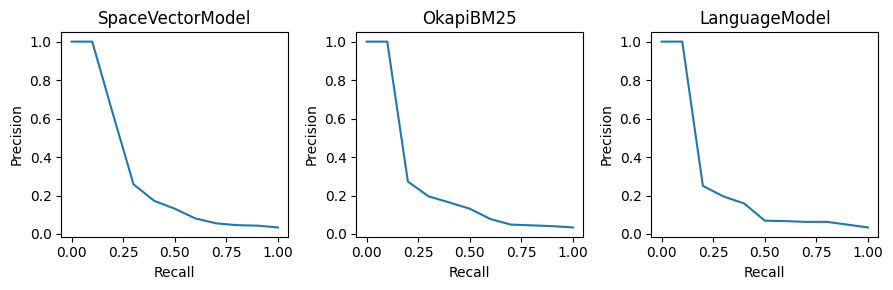

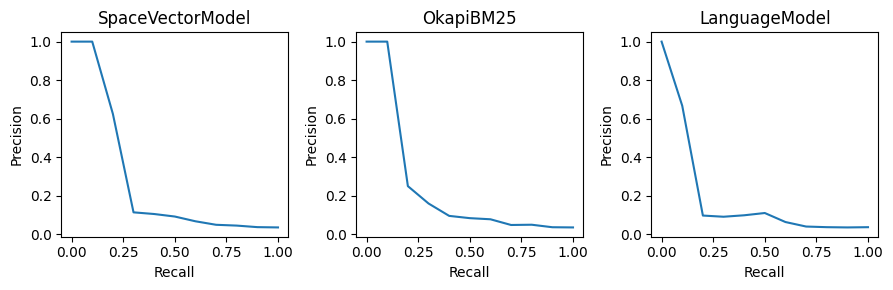

In [320]:
for i in range(2):
    x1, y1 = ElevenPointsInterpolated.calElevenPointsInterpolated(Input.queries["text"][i], Input.queries["num"][i], sp)
    x2, y2 = ElevenPointsInterpolated.calElevenPointsInterpolated(Input.queries["text"][i], Input.queries["num"][i], ok)
    x3, y3 = ElevenPointsInterpolated.calElevenPointsInterpolated(Input.queries["text"][i], Input.queries["num"][i], lm)

    ElevenPointsInterpolated.plot(x1, y1, x2, y2, x3, y3).tight_layout()

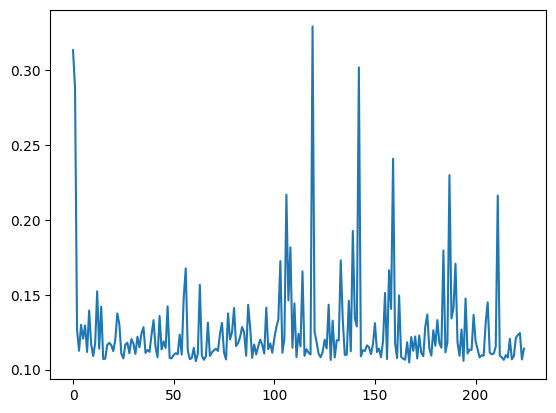

In [338]:
X = np.zeros(len(Input.queries))
Y = np.zeros(len(Input.queries))
index = 0
for ind in Input.queries.index:
    X[index] = index
    Y[index] = ElevenPointsInterpolated.averagePrecision(Input.queries["text"][ind], Input.queries["num"][ind], sp)
    index+=1

plt.plot(X[:index], Y[:index])
plt.show()

In [339]:
pr = reduce(lambda a, b: a + b, Y[:index]) / len(Y[:index]) * 100
recall_levels = [i / 10.0 for i in range(11)]
re = reduce(lambda a, b: a + b, recall_levels) / len(recall_levels) * 100

f_measure_avg = 2 * (pr * re) / (pr + re)
print(f_measure_avg)

20.168613586037914


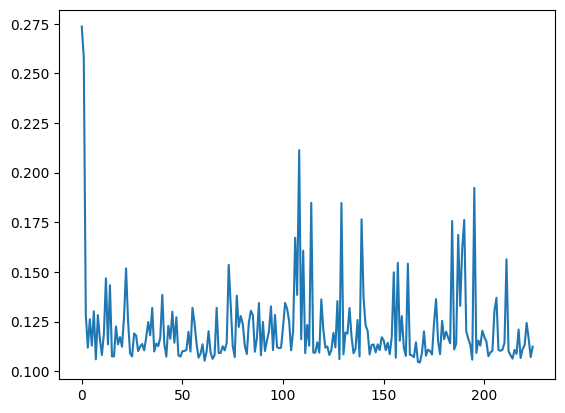

In [340]:
X = np.zeros(len(Input.queries))
Y = np.zeros(len(Input.queries))
index = 0
for ind in Input.queries.index:
    X[index] = index
    Y[index] = ElevenPointsInterpolated.averagePrecision(Input.queries["text"][ind], Input.queries["num"][ind], ok)
    index+=1

plt.plot(X[:index], Y[:index])
plt.show()

In [341]:
pr = reduce(lambda a, b: a + b, Y[:index]) / len(Y[:index]) * 100
recall_levels = [i / 10.0 for i in range(11)]
re = reduce(lambda a, b: a + b, recall_levels) / len(recall_levels) * 100

f_measure_avg = 2 * (pr * re) / (pr + re)
print(f_measure_avg)

19.576190475995027


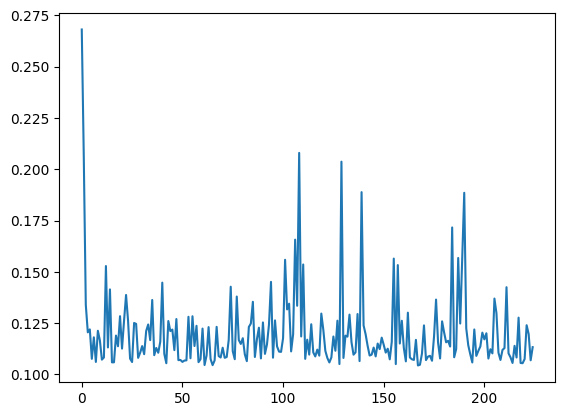

In [344]:
X = np.zeros(len(Input.queries))
Y = np.zeros(len(Input.queries))
index = 0
for ind in Input.queries.index:
    X[index] = index
    Y[index] = ElevenPointsInterpolated.averagePrecision(Input.queries["text"][ind], Input.queries["num"][ind], lm)
    index+=1

plt.plot(X[:index], Y[:index])
plt.show()

In [345]:
pr = reduce(lambda a, b: a + b, Y[:index]) / len(Y[:index]) * 100
recall_levels = [i / 10.0 for i in range(11)]
re = reduce(lambda a, b: a + b, recall_levels) / len(recall_levels) * 100

f_measure_avg = 2 * (pr * re) / (pr + re)
print(f_measure_avg)

19.357516512224997


## Report


#### For this project, I encountered several challenges that I would like to explain:

1.  In the initial step, when attempting to read data from XML files, I encountered numerous errors for which I couldn't identify the root cause. After thorough checks, I discovered a syntax issue in the XML documents file. I then devised the best approach to resolve this problem and successfully read the documents.

2.  While designing my first space vector model, I measured the time complexity of creating the TF-IDF matrix. I found that it took approximately 82 seconds. However, after creating an inverted index first and then using it to build my TF-IDF matrix, the process only took about 1 millisecond.

3.  I was unfamiliar with the 11 points interpolated approach for evaluating results, making it one of the most challenging aspects of this homework for me.

#### Best Algorithm:

In this section, I measured F-measure with the 11 points evaluation average method. I calculated the average of recalls as a recall average, determined precisions at these 11 recall points, and then calculated the average precision. Subsequently, I computed the F-measure using these values.

The final result indicates that the `Space Vector Model` was the most effective approach.


#### Refrences:

1. https://www.geeksforgeeks.org/
2. https://pandas.pydata.org/docs/
3. https://chat.openai.com/
